# Model Training (Keras)

## Configuration

In [29]:
# The parameter file is where the hyperparameters are set

from parameters import *

## Library

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import load_model

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [31]:
seed = 0

# Input seed value. if this value is the same, the random number generator will generate the same set of random values every time
np.random.seed(seed)

# Set the seed value for reproducibility in tensorflow
tf.random.set_seed(seed)

## Check GPU

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14676890929965754991
xla_global_id: -1
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16516343401849318856
physical_device_desc: "device: XLA_CPU device"
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8502378496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1023565322442576091
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:00:10.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7656678861528795608
physical_device_desc: "device: XLA_GPU device"
xla_global_id: -1
]


2024-11-22 03:47:31.938660: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-11-22 03:47:31.939722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 03:47:31.966001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 03:47:31.966436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there 

## Dataset

### Load

In [33]:
if DATA_AUGMENTATION:
    if 'Try Both' not in ENCODING_TYPE:
        X_train = np.load('{}/npy/x_train_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val = np.load('{}/npy/x_val_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test = np.load('{}/npy/x_test_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_train = np.load('{}/npy/y_train_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_val = np.load('{}/npy/y_val_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_augmented.npy'.format(DATA_DIR), allow_pickle=True)
    
    elif 'Try Both' in ENCODING_TYPE:
        X_train_one_hot_encoding = np.load('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_one_hot_encoding = np.load('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_one_hot_encoding = np.load('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_one_hot_encoding = np.load('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_one_hot_encoding = np.load('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_one_hot_encoding = np.load('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

        X_train_linear_encoding = np.load('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_linear_encoding = np.load('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_linear_encoding = np.load('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_linear_encoding = np.load('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_linear_encoding = np.load('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_linear_encoding = np.load('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), allow_pickle=True)

else:
    if 'Try Both' not in ENCODING_TYPE:
        X_train = np.load('{}/npy/x_train.npy'.format(DATA_DIR), allow_pickle=True)
        X_val = np.load('{}/npy/x_val.npy'.format(DATA_DIR), allow_pickle=True)
        X_test = np.load('{}/npy/x_test.npy'.format(DATA_DIR), allow_pickle=True)
        y_train = np.load('{}/npy/y_train.npy'.format(DATA_DIR), allow_pickle=True)
        y_val = np.load('{}/npy/y_val.npy'.format(DATA_DIR), allow_pickle=True)
        y_test = np.load('{}/npy/y_test.npy'.format(DATA_DIR), allow_pickle=True)
    
    elif 'Try Both' in ENCODING_TYPE:
        X_train_one_hot_encoding = np.load('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_one_hot_encoding = np.load('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_one_hot_encoding = np.load('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_one_hot_encoding = np.load('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_one_hot_encoding = np.load('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_one_hot_encoding = np.load('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)

        X_train_linear_encoding = np.load('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_val_linear_encoding = np.load('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        X_test_linear_encoding = np.load('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_linear_encoding = np.load('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_val_linear_encoding = np.load('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_linear_encoding = np.load('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)


FileNotFoundError: [Errno 2] No such file or directory: 'data/npy/x_train_one_hot_encoding_augmented.npy'

### Visualize

In [ ]:
if 'Try Both' not in ENCODING_TYPE:
    print('X_train.shape: ', X_train.shape)
    print('X_val.shape: ', X_val.shape)
    print('y_train.shape: ', y_train.shape)
    print('y_val.shape: ', y_val.shape)
    print('y_train[0]: ', y_train[0])
else:
    print('X_train_linear_encoding.shape: ', X_train_linear_encoding.shape)
    print('X_val_linear_encoding.shape: ', X_val_linear_encoding.shape)
    print('y_train_linear_encoding.shape: ', y_train_linear_encoding.shape)
    print('y_val_linear_encoding.shape: ', y_val_linear_encoding.shape)
    print('y_train_linear_encoding[0]: ', y_train_linear_encoding[0])

    print('X_train_one_hot_encoding.shape: ', X_train_one_hot_encoding.shape)
    print('X_val_one_hot_encoding.shape: ', X_val_one_hot_encoding.shape)
    print('y_train_one_hot_encoding.shape: ', y_train_one_hot_encoding.shape)
    print('y_val_one_hot_encoding.shape: ', y_val_one_hot_encoding.shape)
    print('y_train_one_hot_encoding[0]: ', y_train_one_hot_encoding[0])

In [34]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train) #can check this in previous script as well after loading to make sure it matches
else:
    display(X_train_one_hot_encoding)
    display(X_train_linear_encoding)

array([[0.33514963, 0.00078676],
       [0.01809174, 0.15265725],
       [0.01032841, 0.14763822],
       ...,
       [0.05754841, 0.25609945],
       [0.57781303, 0.0013409 ],
       [0.06168676, 0.26742149]])

array([[0.33514963, 0.00078676],
       [0.01809174, 0.15265725],
       [0.01032841, 0.14763822],
       ...,
       [0.05754841, 0.25609945],
       [0.57781303, 0.0013409 ],
       [0.06168676, 0.26742149]])

In [35]:
if 'Try Both' not in ENCODING_TYPE:
    total = len(X_train) + len(X_test) + len(X_val)
    print('---------------------------------------')  
    print('Train set shape x:                {}, {:.2f}%'.format(len(X_train), (len(X_train)*100.)/total))
    print('Validation set shape x:           {}, {:.2f}%'.format(len(X_train), (len(X_val)*100.)/total))
    print('Test set shape x:                 {}, {:.2f}%'.format(len(X_test), (len(X_test)*100.)/total))
    print('---------------------------------------')

    total = len(y_train) + len(y_test) + len(y_val)
    print('---------------------------------------')  
    print('Train set shape y:                {}, {:.2f}%'.format(len(y_train), (len(y_train)*100.)/total))
    print('Validation set shape y:           {}, {:.2f}%'.format(len(y_val), (len(y_val)*100.)/total))
    print('Test set shape y:                 {}, {:.2f}%'.format(len(y_test), (len(y_test)*100.)/total))
    print('---------------------------------------')
else:
    total = len(X_train_one_hot_encoding) + len(X_test_one_hot_encoding) + len(X_val_one_hot_encoding)
    print('---------------------------------------')  
    print('Train set shape x one_hot_encoding:      {}, {:.2f}%'.format(len(X_train_one_hot_encoding), (len(X_train_one_hot_encoding)*100.)/total))
    print('Validation set shape x one_hot_encoding: {}, {:.2f}%'.format(len(X_train_one_hot_encoding), (len(X_val_one_hot_encoding)*100.)/total))
    print('Test set shape x one_hot_encoding:       {}, {:.2f}%'.format(len(X_test_one_hot_encoding), (len(X_test_one_hot_encoding)*100.)/total))
    print('---------------------------------------')

    total = len(y_train_one_hot_encoding) + len(y_test_one_hot_encoding) + len(y_val_one_hot_encoding)
    print('---------------------------------------')  
    print('Train set shape y one_hot_encoding:         {}, {:.2f}%'.format(len(y_train_one_hot_encoding), (len(y_train_one_hot_encoding)*100.)/total))
    print('Validation set shape y one_hot_encoding:    {}, {:.2f}%'.format(len(y_val_one_hot_encoding), (len(y_val_one_hot_encoding)*100.)/total))
    print('Test set shape y one_hot_encoding:          {}, {:.2f}%'.format(len(y_test_one_hot_encoding), (len(y_test_one_hot_encoding)*100.)/total))


    total = len(X_train_linear_encoding) + len(X_test_linear_encoding) + len(X_val_linear_encoding)
    print('---------------------------------------')  
    print('Train set shape x linear_encoding:      {}, {:.2f}%'.format(len(X_train_linear_encoding), (len(X_train_linear_encoding)*100.)/total))
    print('Validation set shape x linear_encoding: {}, {:.2f}%'.format(len(X_train_linear_encoding), (len(X_val_linear_encoding)*100.)/total))
    print('Test set shape x linear_encoding:       {}, {:.2f}%'.format(len(X_test_linear_encoding), (len(X_test_linear_encoding)*100.)/total))
    print('---------------------------------------')

    total = len(y_train_linear_encoding) + len(y_test_linear_encoding) + len(y_val_linear_encoding)
    print('---------------------------------------')  
    print('Train set shape y linear_encoding:         {}, {:.2f}%'.format(len(y_train_linear_encoding), (len(y_train_linear_encoding)*100.)/total))
    print('Validation set shape y linear_encoding:    {}, {:.2f}%'.format(len(y_val_linear_encoding), (len(y_val_linear_encoding)*100.)/total))
    print('Test set shape y linear_encoding:          {}, {:.2f}%'.format(len(y_test_linear_encoding), (len(y_test_linear_encoding)*100.)/total))

---------------------------------------
Train set shape x one_hot_encoding:      851, 69.98%
Validation set shape x one_hot_encoding: 851, 14.97%
Test set shape x one_hot_encoding:       183, 15.05%
---------------------------------------
---------------------------------------
Train set shape y one_hot_encoding:         851, 69.98%
Validation set shape y one_hot_encoding:    182, 14.97%
Test set shape y one_hot_encoding:          183, 15.05%
---------------------------------------
Train set shape x linear_encoding:      851, 69.98%
Validation set shape x linear_encoding: 851, 14.97%
Test set shape x linear_encoding:       183, 15.05%
---------------------------------------
---------------------------------------
Train set shape y linear_encoding:         851, 69.98%
Validation set shape y linear_encoding:    182, 14.97%
Test set shape y linear_encoding:          183, 15.05%


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

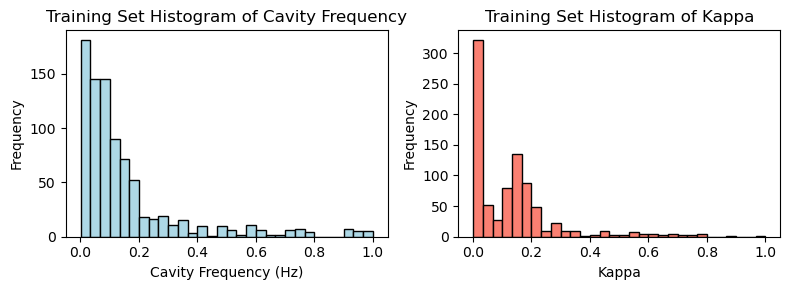

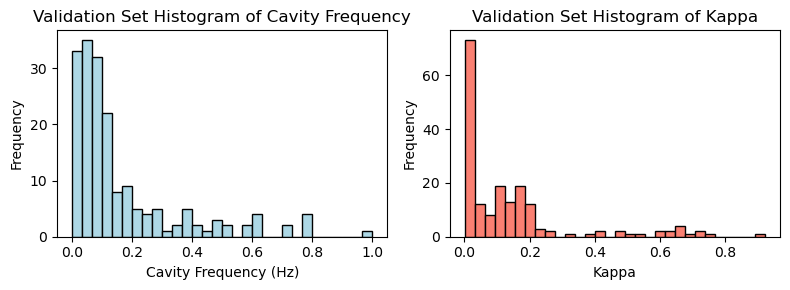

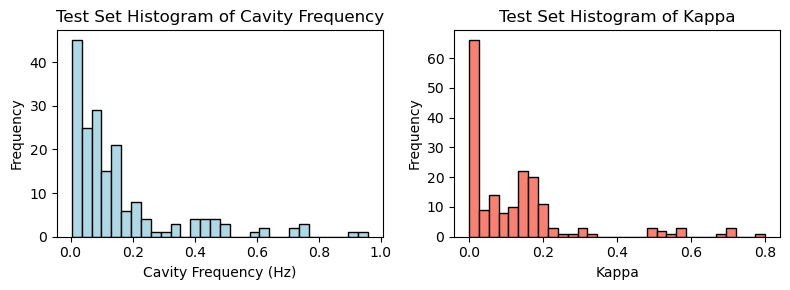

In [37]:
if 'Try Both' not in ENCODING_TYPE:
    #--------------------Training Set---------------------
    plt.figure(figsize=(8, 3))
    
    # Histogram for Cavity Frequency
    plt.subplot(1, 2, 1)
    plt.hist([i[0] for i in X_train], bins=30, color='lightblue', edgecolor='black')
    plt.title('Training Set Histogram of Cavity Frequency')
    plt.xlabel('Cavity Frequency (Hz)')
    plt.ylabel('Frequency')
    
    # Histogram for Kappa
    plt.subplot(1, 2, 2)
    plt.hist([i[1] for i in X_train], bins=30, color='salmon', edgecolor='black')
    plt.title('Training Set Histogram of Kappa')
    plt.xlabel('Kappa')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    #--------------------Validation Set---------------------
    plt.figure(figsize=(8, 3))
    
    # Histogram for Cavity Frequency
    plt.subplot(1, 2, 1)
    plt.hist([i[0] for i in X_val], bins=30, color='lightblue', edgecolor='black')
    plt.title('Validation Set Histogram of Cavity Frequency')
    plt.xlabel('Cavity Frequency (Hz)')
    plt.ylabel('Frequency')
    
    # Histogram for Kappa
    plt.subplot(1, 2, 2)
    plt.hist([i[1] for i in X_val], bins=30, color='salmon', edgecolor='black')
    plt.title('Validation Set Histogram of Kappa')
    plt.xlabel('Kappa')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    #--------------------Test Set---------------------
    plt.figure(figsize=(8, 3))
    
    # Histogram for Cavity Frequency
    plt.subplot(1, 2, 1)
    plt.hist([i[0] for i in X_test], bins=30, color='lightblue', edgecolor='black')
    plt.title('Test Set Histogram of Cavity Frequency')
    plt.xlabel('Cavity Frequency (Hz)')
    plt.ylabel('Frequency')
    
    # Histogram for Kappa
    plt.subplot(1, 2, 2)
    plt.hist([i[1] for i in X_test], bins=30, color='salmon', edgecolor='black')
    plt.title('Test Set Histogram of Kappa')
    plt.xlabel('Kappa')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
else:
    #--------------------Training Set---------------------
    plt.figure(figsize=(8, 3))
    
    # Histogram for Cavity Frequency
    plt.subplot(1, 2, 1)
    plt.hist([i[0] for i in X_train_linear_encoding], bins=30, color='lightblue', edgecolor='black')
    plt.title('Training Set Histogram of Cavity Frequency')
    plt.xlabel('Cavity Frequency (Hz)')
    plt.ylabel('Frequency')
    
    # Histogram for Kappa
    plt.subplot(1, 2, 2)
    plt.hist([i[1] for i in X_train_linear_encoding], bins=30, color='salmon', edgecolor='black')
    plt.title('Training Set Histogram of Kappa')
    plt.xlabel('Kappa')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    #--------------------Validation Set---------------------
    plt.figure(figsize=(8, 3))
    
    # Histogram for Cavity Frequency
    plt.subplot(1, 2, 1)
    plt.hist([i[0] for i in X_val_linear_encoding], bins=30, color='lightblue', edgecolor='black')
    plt.title('Validation Set Histogram of Cavity Frequency')
    plt.xlabel('Cavity Frequency (Hz)')
    plt.ylabel('Frequency')
    
    # Histogram for Kappa
    plt.subplot(1, 2, 2)
    plt.hist([i[1] for i in X_val_linear_encoding], bins=30, color='salmon', edgecolor='black')
    plt.title('Validation Set Histogram of Kappa')
    plt.xlabel('Kappa')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    
    #--------------------Test Set---------------------
    plt.figure(figsize=(8, 3))
    
    # Histogram for Cavity Frequency
    plt.subplot(1, 2, 1)
    plt.hist([i[0] for i in X_test_linear_encoding], bins=30, color='lightblue', edgecolor='black')
    plt.title('Test Set Histogram of Cavity Frequency')
    plt.xlabel('Cavity Frequency (Hz)')
    plt.ylabel('Frequency')
    
    # Histogram for Kappa
    plt.subplot(1, 2, 2)
    plt.hist([i[1] for i in X_test_linear_encoding], bins=30, color='salmon', edgecolor='black')
    plt.title('Test Set Histogram of Kappa')
    plt.xlabel('Kappa')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## MLP

### Create model

Create a classical multi-layer perceptron for regression: 602 input features, 10 targets, and a certain number of hidden layers and neurons. Taking some inspiration from [Deep learning-based I-V Global Parameter Extraction for BSIM-CMG](https://www.sciencedirect.com/science/article/pii/S003811012300179X), Solid-State Electronics, Vol. 209, November 2023.

Reccomended to download a third party app like "Sleep control Center" or "Amphetamine" to prevent computer from sleeping during the many hour/day long training process

### Create Model by Hand

In [38]:
if not KERAS_TUNER:
    # n output neurons for n parameters
    if 'Try Both' not in ENCODING_TYPE:
        # Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
        model_shape = f'mlp_{len(X_test[0])}_'
        
        # Define the number on neurons in the inner layer (in parameter file)
        model_shape += '_'.join(str(l) for l in NEURONS_PER_LAYER)
    
        print(len(y_train[0]))
        model_shape += f'_{len(y_train[0])}'
    else:
        # Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
        model_shape_one_hot_encoding = f'mlp_{len(X_test_one_hot_encoding[0])}_'
        model_shape_linear_encoding = f'mlp_{len(X_test_one_hot_encoding[0])}_'
        
        # Define the number on neurons in the inner layer (in parameter file)
        model_shape_one_hot_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)
        model_shape_linear_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)
    
        print('one hot: ',len(y_train_one_hot_encoding[0]))
        model_shape_one_hot_encoding += f'_{len(y_train_one_hot_encoding[0])}'
        print('linear: ',len(y_train_linear_encoding[0]))
        model_shape_linear_encoding += f'_{len(y_train_linear_encoding[0])}'


In [39]:
if not KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        # Initialize a sequential model, which lets us build a linear stack of layers
        model = Sequential()
        
        # Add an input layer to the model. This layer defines the shape of the input data (2 features per sample), sets dimensions of following layers
        model.add(Input(shape=(len(X_test[0])), name='input1'))
        
        # Iterate over the configuration of neurons for each hidden layer specified in NEURONS_PER_LAYER
        for i, n in enumerate(NEURONS_PER_LAYER):
            # Add a fully connected (dense) hidden layer with spec ified number of neurons
            # The LeCun uniform initializer is used when initializing weights, this makes the model more stable
            # L2 regularization is used in each layer to penalizing large weights, which prevents overfitting
            model.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        
            # Apply a Leaky ReLU activation function to the outputs of the dense layer
            # This introduces non-linearities, allowing the network to learn complex functions
            # Leaky ReLU is chosen over standard ReLU to help mitigate the "dying ReLU" problem:
            #     - This problem is when neurons using the ReLU activation function output zero for all inputs and stop learning
            #     - Can be mitigated by using variations like Leaky ReLU or proper initialization
            model.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
            
            # Add a dropout layer to reduce overfitting -- randomly drops a set fraction (like 30%) of outputs from the layer
            model.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
        
        # Add the output layer consisting of # neurons, corresponding to the # target variables we aim to predict.
        # The same LeCun uniform initializer is used to ensure consistency and stability at the output layer as well.
        model.add(Dense(len(y_train[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))
    
    else:
        model_one_hot_encoding = Sequential()
        model_one_hot_encoding.add(Input(shape=(len(X_test_one_hot_encoding[0])), name='input1'))
        for i, n in enumerate(NEURONS_PER_LAYER):
            model_one_hot_encoding.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
            model_one_hot_encoding.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
            model_one_hot_encoding.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
        model_one_hot_encoding.add(Dense(len(y_train_one_hot_encoding[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))
    
        model_linear_encoding = Sequential()
        model_linear_encoding.add(Input(shape=(len(X_test_linear_encoding[0])), name='input1'))
        for i, n in enumerate(NEURONS_PER_LAYER):
            model_linear_encoding.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
            model_linear_encoding.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
            model_linear_encoding.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
        model_linear_encoding.add(Dense(len(y_train_linear_encoding[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))

In [40]:
if not KERAS_TUNER:
    # The exponential decay learning rate schedule gradually reduces the learning rate, fine-tuning the learning process for better convergence
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LR_INITIAL,  
        decay_steps=LR_DECAY_STEPS,        
        decay_rate=LR_DECAY_RATE,          
        staircase=LR_STAIRCASE             
    )
    
    if 'Try Both' not in ENCODING_TYPE:
        # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
            loss=TRAIN_LOSS,                                         
            metrics=[TRAIN_LOSS]                                     
        )
    else:
        # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
        model_linear_encoding.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
            loss=TRAIN_LOSS,                                         
            metrics=[TRAIN_LOSS]                                     
        )
        model_one_hot_encoding.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
            loss=TRAIN_LOSS,                                         
            metrics=[TRAIN_LOSS]                                     
        )

In [41]:
if not KERAS_TUNER:
    !mkdir -p model
    if 'Try Both' not in ENCODING_TYPE:
        best_model_file = 'model/{}_best_model.h5'.format(model_shape)
        last_model_file = 'model/{}_last_model.h5'.format(model_shape)
    else:
        best_model_file_one_hot_encoding = 'model/{}_best_model_one_hot_encoding.h5'.format(model_shape_one_hot_encoding)
        last_model_file_one_hot_encoding = 'model/{}_last_model_one_hot_encoding.h5'.format(model_shape_one_hot_encoding)
    
        best_model_file_linear_encoding = 'model/{}_best_model_linear_encoding.h5'.format(model_shape_linear_encoding)
        last_model_file_linear_encoding = 'model/{}_last_model_linear_encoding.h5'.format(model_shape_linear_encoding)

Enable training (`train_and_save`) to overwrite the model file.

In [42]:
train_and_save = True

We use Adam optimizer, minimize the Mean Squared Logarithmic Error, and early stop.

#### Training

In [43]:
from IPython.display import clear_output
if not KERAS_TUNER:
    class TrainingPlot(tf.keras.callbacks.Callback):
         
        # This function is called when the training begins
        def on_train_begin(self, logs={}):
            # Initialize the lists for holding the logs, losses 
            self.losses = []
            self.val_losses = []
            self.logs = []
        
        # This function is called at the end of each epoch
        def on_epoch_end(self, epoch, logs={}):
            
            # Append the logs, losses  to the lists
            self.logs.append(logs)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            
            # Before plotting ensure at least 2 epochs have passed
            if len(self.losses) > 1:
                
                # Clear the previous plot
                clear_output(wait=True)
                N = np.arange(0, len(self.losses))
                
                # Plot train loss, train acc, val loss and val acc against epochs passed
                plt.figure()
                plt.plot(N, self.losses, label = "train_loss")
                plt.plot(N, self.val_losses, label = "val_loss")
                plt.title("Training Loss [Epoch {}]".format(epoch))
                plt.xlabel("Epoch #")
                plt.ylabel("Loss/Accuracy")
                plt.legend()
                plt.show()
           
    class LearningRateMonitor(tf.keras.callbacks.Callback):
        def __init__(self):
            super(LearningRateMonitor, self).__init__()
            self.learning_rates = []
    
        def on_epoch_end(self, epoch, logs=None):
            lr = self.model.optimizer._current_learning_rate.read_value()
            self.learning_rates.append(lr)
            print(f"Epoch: {epoch + 1}, Learning Rate: {lr:.10f}")

In [44]:
%%time
history = None  
if not KERAS_TUNER:
    if train_and_save: 
        # Set up early stopping to prevent overfitting by halting training when validation loss stops improving
        early_stopping = EarlyStopping(
            monitor='val_loss',                      # Monitor validation loss for stopping criteria 
            mode='min',                              # Stop when the monitored quantity has stopped decreasing
            patience=TRAIN_EARLY_STOPPING_PATIENCE,  # Number of epochs to wait after last improvement
            verbose=1                                # Enable logging when early stopping happens
        )
    
        # Train the model on the training data and validate on a portion of it
        if 'Try Both' not in ENCODING_TYPE:
            plot_callback = TrainingPlot()      # Plot training progress
            lr_monitor = LearningRateMonitor()  # Watch learning rate changes
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint = ModelCheckpoint(
                filepath=best_model_file,          
                monitor='val_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
    
            history = model.fit(
                np.asarray(X_train),  
                np.asarray(y_train),      
                epochs=100,                   
                batch_size=TRAIN_BATCH_SIZE,  
                validation_data=(np.asarray(X_val), np.asarray(y_val)),  
                callbacks=[early_stopping, model_checkpoint, plot_callback, lr_monitor],  
                verbose=1  # Enable logging of the training process.
            )
            
            model.save(last_model_file)  # Save the final model when done training!
        
        else:
            #-----------------------------------------linear--------------------------------------------
            plot_callback_linear_encoding = TrainingPlot()      # Plot training progress
            lr_monitor_linear_encoding = LearningRateMonitor()  # Watch learning rate changes
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint_linear_encoding = ModelCheckpoint(
                filepath=best_model_file_linear_encoding,          
                monitor='val_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
            
            history_linear_encoding = model_linear_encoding.fit(
                np.asarray(X_train_linear_encoding),  
                np.asarray(y_train_linear_encoding),      
                epochs=100,                   
                batch_size=TRAIN_BATCH_SIZE,  
                validation_data=(np.asarray(X_val_linear_encoding), np.asarray(y_val_linear_encoding)), 
                callbacks=[early_stopping, model_checkpoint_linear_encoding, plot_callback_linear_encoding, lr_monitor_linear_encoding],  
                verbose=1  # Enable logging of the training process.
            )
            
            model_linear_encoding.save(last_model_file_linear_encoding)  # Save the final model when done training!
            
            #-----------------------------------------one hot--------------------------------------------
            plot_callback_one_hot_encoding = TrainingPlot()      # Plot training progress
            lr_monitor_one_hot_encoding = LearningRateMonitor()  # Watch learning rate changes
            
            # Set up model checkpointing to save the model at its best validation loss:
            model_checkpoint_one_hot_encoding = ModelCheckpoint(
                filepath=best_model_file_one_hot_encoding,          
                monitor='val_loss',            # Save the model based on validation loss improvement
                mode='min',                    # Favor lower validation loss values for saving (minimize)
                save_best_only=True,           # Save only when validation loss improves
                verbose=0                      # No logging for model saving
            )
            
            history_one_hot_encoding = model_one_hot_encoding.fit(
                np.asarray(X_train_one_hot_encoding),  
                np.asarray(y_train_one_hot_encoding),      
                epochs=100,                   
                batch_size=TRAIN_BATCH_SIZE,  
                validation_data=(np.asarray(X_val_one_hot_encoding), np.asarray(y_val_one_hot_encoding)), 
                callbacks=[early_stopping, model_checkpoint_one_hot_encoding, plot_callback_one_hot_encoding, lr_monitor_one_hot_encoding],  
                verbose=1  # Enable logging of the training process.
            )
            
            model_one_hot_encoding.save(last_model_file_one_hot_encoding)  # Save the final model when done training!


CPU times: user 12 μs, sys: 1 μs, total: 13 μs
Wall time: 22.9 μs


Load the saved best model and use it from now on.

In [45]:
if not KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        model = load_model(best_model_file, custom_objects={})
    else:
        model_one_hot_encoding = load_model(best_model_file_one_hot_encoding, custom_objects={})
        model_linear_encoding = load_model(best_model_file_linear_encoding, custom_objects={})

### Keras Tuner to Find Best Hyperparameters and Model

Run this if you want to use keras tuner to make the model rather than doing it by hand

In [46]:
if KERAS_TUNER:
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Input, Dropout
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras_tuner import HyperModel, RandomSearch
    from tensorflow.keras.models import load_model

In [47]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        def build_hypermodel(hp):
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            # Create Model in the same way that we do by hand
            model = Sequential()
            model.add(Input(shape=(len(X_test[0]),), name='input1'))
        
            for i, n in enumerate(neurons_per_layer):
                model.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
                model.add(LeakyReLU(alpha=0.01, name=f'leaky_relu{i}'))
                model.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
        
            model.add(Dense(len(y_train[0]), name='output', kernel_initializer='lecun_uniform'))
        
            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr_initial,
                decay_steps=LR_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
                staircase=LR_STAIRCASE
            )
        
            model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            return model
    else:
        def build_hypermodel_one_hot_encoding(hp):
             # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            #----------------------------------------------one hot-------------------------------------------
            # Create Model in the same way that we do by hand
            model_one_hot_encoding = Sequential()
            model_one_hot_encoding.add(Input(shape=(len(X_test_one_hot_encoding[0]),), name='input1'))
        
            for i, n in enumerate(neurons_per_layer):
                model_one_hot_encoding.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
                model_one_hot_encoding.add(LeakyReLU(alpha=0.01, name=f'leaky_relu{i}'))
                model_one_hot_encoding.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
        
            model_one_hot_encoding.add(Dense(len(y_train_one_hot_encoding[0]), name='output', kernel_initializer='lecun_uniform'))
            
            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr_initial,
                decay_steps=LR_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
                staircase=LR_STAIRCASE
            )

            optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
            model_one_hot_encoding.compile(optimizer=optimizer, 
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            return model_one_hot_encoding

        def build_hypermodel_linear_encoding(hp):
            # Hyperparameters to tune
            neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
            dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
            
            #----------------------------------------------linear------------------------------------------- 
            # Create Model in the same way that we do by hand
            model_linear_encoding = Sequential()
            model_linear_encoding.add(Input(shape=(len(X_test_linear_encoding[0]),), name='input1'))
        
            for i, n in enumerate(neurons_per_layer):
                model_linear_encoding.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
                model_linear_encoding.add(LeakyReLU(alpha=0.01, name=f'leaky_relu{i}'))
                model_linear_encoding.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
        
            model_linear_encoding.add(Dense(len(y_train_linear_encoding[0]), name='output', kernel_initializer='lecun_uniform'))
            #----------------------------------------------continue-------------------------------------------

            # Learning rate configuration
            lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr_initial,
                decay_steps=LR_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
                staircase=LR_STAIRCASE
            )
            optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
            model_linear_encoding.compile(optimizer=optimizer, 
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            return model_linear_encoding

In [48]:
if 'Try Both' not in ENCODING_TYPE:
    if KERAS_TUNER:
        # Start tuning
        tuner = RandomSearch(
            build_hypermodel,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory='hyper_tuning',
            project_name='mlp_tuning'
        )
else:
    if KERAS_TUNER:
        # Start tuning linear encoding
        tuner_linear_encoding = RandomSearch(
            build_hypermodel_linear_encoding,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory='hyper_tuning_linear_encoding',
            project_name='mlp_tuning_linear_encoding'
        )

        # Start tuning one hot encoding
        tuner_one_hot_encoding = RandomSearch(
            build_hypermodel_one_hot_encoding,
            objective='val_loss',
            max_trials=KERAS_TUNER_TRIALS,
            executions_per_trial=1,
            directory='hyper_tuning_one_hot_encoding',
            project_name='mlp_tuning_one_hot_encoding'
        )
    

In [49]:
if KERAS_TUNER:
    # Setup Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=TRAIN_EARLY_STOPPING_PATIENCE,
        verbose=1
    )

In [ ]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        # Perform hyperparameter tuning
        tuner.search(np.asarray(X_train), 
                     np.asarray(y_train), 
                     epochs=50, 
                     batch_size=TRAIN_BATCH_SIZE, 
                     validation_data=(np.asarray(X_val), np.asarray(y_val)),
                     callbacks=[early_stopping], 
                     verbose=1)
    else:
        # Perform hyperparameter tuning
        tuner_one_hot_encoding.search(np.asarray(X_train_one_hot_encoding), 
                     np.asarray(y_train_one_hot_encoding), 
                     epochs=50, 
                     batch_size=TRAIN_BATCH_SIZE, 
                     validation_data=(np.asarray(X_val_one_hot_encoding), np.asarray(y_val_one_hot_encoding)),
                     callbacks=[early_stopping], 
                     verbose=1)

        tuner_linear_encoding.search(np.asarray(X_train_linear_encoding), 
                     np.asarray(y_train_linear_encoding), 
                     epochs=50, 
                     batch_size=TRAIN_BATCH_SIZE, 
                     validation_data=(np.asarray(X_val_linear_encoding), np.asarray(y_val_linear_encoding)),
                     callbacks=[early_stopping], 
                     verbose=1)

Trial 1 Complete [00h 01m 37s]
val_loss: 8.243383407592773

Best val_loss So Far: 8.243383407592773
Total elapsed time: 00h 01m 37s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1800              |800               |neurons_0
2100              |2100              |neurons_1
1700              |3300              |neurons_2
4200              |3300              |neurons_3
0.4               |0.4               |dropout_rate
7.6552e-05        |2.4172e-06        |learning_rate

Epoch 1/50
27/27 [==============================] - 5s 32ms/step - loss: 9.5311 - mean_squared_error: 0.1389 - val_loss: 9.0606 - val_mean_squared_error: 0.1014
Epoch 2/50
27/27 [==============================] - 1s 21ms/step - loss: 8.6857 - mean_squared_error: 0.0979 - val_loss: 8.2801 - val_mean_squared_error: 0.0925
Epoch 3/50
27/27 [==============================] - 3s 96ms/step - loss: 7.9378 - mean_squared_error: 0.0887 - val_loss: 7.5683 - val_mean_squared_error: 0.0828
Epoch 4/5

In [ ]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        model = tuner.get_best_models(num_models=1)[0]
        print(model)
    else:
        model_linear_encoding = tuner_linear_encoding.get_best_models(num_models=1)[0]
        print(model_linear_encoding)
        model_one_hot_encoding = tuner_one_hot_encoding.get_best_models(num_models=1)[0]
        print(model_one_hot_encoding)

In [ ]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        best_model_file = 'model/best_keras_model.h5'
        model.save(best_model_file)
        
        model = load_model(best_model_file)
    else:
        best_model_file_linear_encoding = 'model/best_keras_model_linear_encoding.h5'
        best_model_file_one_hot_encoding = 'model/best_keras_model_one_hot_encoding.h5'
        model_one_hot_encoding.save(best_model_file_one_hot_encoding)
        model_linear_encoding.save(best_model_file_linear_encoding)
        
        model_linear_encoding = load_model(best_model_file_linear_encoding)
        model_one_hot_encoding = load_model(best_model_file_one_hot_encoding)

### View the model

In [ ]:
if KERAS_TUNER:
    if 'Try Both' not in ENCODING_TYPE:
        model.summary()
    else:
        model_one_hot_encoding.summary()
        model_linear_encoding.summary()

In [ ]:
if KERAS_TUNER:
    #pip install --upgrade pydot
    def get_model_shape_string(model):
        """Extracts model shape information directly from model layers.
    
        Args:
          model: A Keras model instance.
    
        Returns:
          A string representing the model shape. Returns an error message if the 
          model architecture is not supported.
        """
        try:
            input_shape = model.input_shape[1] # Assumes a single input layer
            output_shape = model.output_shape[-1] # Assumes last dimension is output size
    
            layer_sizes = [layer.units for layer in model.layers if hasattr(layer, 'units')]
    
            model_shape = f"mlp_{input_shape}_" + "_".join(map(str, layer_sizes)) + f"_{output_shape}"
            return model_shape
        except (AttributeError, IndexError) as e:
            return f"Error getting model shape: {e}.  Unsupported model architecture?"
    

    if 'Try Both' not in ENCODING_TYPE:
        model_shape = get_model_shape_string(model)
        tf.keras.utils.plot_model(model, to_file='{}_model.png'.format(model_shape), show_shapes=True, show_layer_names=True)
    else:
        model_shape_one_hot = get_model_shape_string(model_one_hot_encoding)
        model_shape_linear = get_model_shape_string(model_linear_encoding)
        tf.keras.utils.plot_model(model_linear_encoding, to_file='{}_model_linear_encoding.png'.format(model_shape_linear), show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(model_one_hot_encoding, to_file='{}_model_one_hot_encoding.png'.format(model_shape_one_hot), show_shapes=True, show_layer_names=True)
else:
    if 'Try Both' not in ENCODING_TYPE:
        tf.keras.utils.plot_model(model, to_file='{}_model.png'.format(model_shape), show_shapes=True, show_layer_names=True)
    else:
        tf.keras.utils.plot_model(model_linear_encoding, to_file='{}_model_linear_encoding.png'.format(model_shape_linear_encoding), show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(model_one_hot_encoding, to_file='{}_model_one_hot_encoding.png'.format(model_shape_one_hot_encoding), show_shapes=True, show_layer_names=True)
    

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history.

In [ ]:
#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
if 'Try Both' not in ENCODING_TYPE:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
else:
    plt.plot(history_linear_encoding.history['loss'])
    plt.plot(history_linear_encoding.history['val_loss'])
    plt.title('Model loss linear encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

    plt.plot(history_one_hot_encoding.history['loss'])
    plt.plot(history_one_hot_encoding.history['val_loss'])
    plt.title('Model loss one hot encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [ ]:
if 'Try Both' not in ENCODING_TYPE:
    plt.plot(lr_monitor.learning_rates)
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()
else:
    plt.plot(lr_monitor_linear_encoding.learning_rates)
    plt.title("Learning Rate over Epochs linear encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()

    plt.plot(lr_monitor_one_hot_encoding.learning_rates)
    plt.title("Learning Rate over Epochs one hot encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()

Measure and print metrics.

In [ ]:
if 'Try Both' not in ENCODING_TYPE:
    test_loss_result = model.evaluate(np.asarray(X_test), np.asarray(y_test))[0]
    print(y_test[0])
    print('test_loss_result: ', test_loss_result)
else:
    test_loss_result_linear_encoding = model_linear_encoding.evaluate(np.asarray(X_test_linear_encoding), np.asarray(y_test_linear_encoding))[0]
    test_loss_result_one_hot_encoding = model_one_hot_encoding.evaluate(np.asarray(X_test_one_hot_encoding), np.asarray(y_test_one_hot_encoding))[0]

    print(y_test_linear_encoding[0])
    print(y_test_linear_encoding[0])
    
    print('Current loss linear encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_linear_encoding))
    print('Current loss one hot encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_one_hot_encoding))

## Compare predictions vs. test set

In [ ]:
import csv
if 'Try Both' not in ENCODING_TYPE:
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape,
        ENCODING_TYPE,
        test_loss_result,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
    
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df = df.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

else:
    #---------------------------------------------------one hot---------------------------------------
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape_one_hot_encoding,
        'One Hot',
        test_loss_result_one_hot_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
            
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df_one_hot_encoding = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_one_hot_encoding = df_one_hot_encoding.style.apply(color_red_column, subset=['test_loss'])
    #---------------------------------------------------linear---------------------------------------
    csv_data_linear_encoding = [[
        DATA_AUGMENTATION,
        model_shape_linear_encoding,
        'Linear',
        test_loss_result_linear_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        '0.15/0.15',
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file_linear_encoding = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    with open(csv_file_linear_encoding, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data_linear_encoding)
    
    # Convert data to DataFrame for easier display
    df_linear_encoding = pd.read_csv(csv_file_linear_encoding)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_linear_encoding = df_linear_encoding.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df_linear_encoding)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

In [ ]:
#chose the one model you want to see more in depth
if 'Try Both' not in ENCODING_TYPE:
    y_pred = model.predict(np.array(X_test))
    y_encoding_format_name = 'one_hot'
else:
    if test_loss_result_linear_encoding < test_loss_result_one_hot_encoding:
        y_pred = model_linear_encoding.predict(np.array(X_test_linear_encoding))
        y_test = y_test_linear_encoding
        y_encoding_format_name = 'linear'
    else:
        y_pred = model_one_hot_encoding.predict(np.array(X_test_one_hot_encoding))
        y_test = y_test_one_hot_encoding
        y_encoding_format_name = 'one_hot'

In [ ]:
filename = f'y_characteristics_{y_encoding_format_name}_encoding.csv'
with open(filename, 'r') as f:
            headers_string = f.readline().strip()  # Read the first line (headers) and remove whitespace
            headers = headers_string.split(',') 
#print(headers)

pow2_errors = [(y_test[i]-y_pred[i][0])**2 for i in range(len(y_pred))]
abs_errors = [abs(y_test[i]-y_pred[i][0]) for i in range(len(y_pred))]

print('---------------------------------------------------Scaled predictions----------------------------------------------')
min=1
for i in range(2): 
    if abs_errors[i].any()<min: 
        min = abs_errors[i]
    print(f"---------------------- X Values: cavity_frequency:{X_test[i][0]} 	kappa: {X_test[i][1]}-----------------------")
    for l in range(len(y_test[i])):
        print('Param: {}, Ref: {}, Pred: {}, Pow2Er: {}, AbsEr: {}'.format(headers[l],y_test[i][l], y_pred[i][l], pow2_errors[i][l], abs_errors[i][l]))
    print("")

### Unscaled test vs predictions

In [ ]:
# Unscale X
import joblib
X_index_names = ['cavity_frequency','kappa']

X_test_unscaled = X_test.copy()
for i, row in enumerate(X_test_unscaled):
    for j, val in enumerate(row):
        scaler = joblib.load(f'scalers/scaler_X_{X_index_names[j]}.save')
        X_test_unscaled[i][j] = scaler.inverse_transform([[val]])[0][0] # Access the single value from the array

# X_unscaled is now a list of lists with inverse transformed values
print(X_test_unscaled[0])


# Unscale y
y_test_unscaled = y_test.copy()
for i, row in enumerate(y_test_unscaled):
    for j, val in enumerate(row):
        scaler = joblib.load(f'scalers/scaler_y_{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_test_unscaled[i][j] = scaler.inverse_transform([[val]])[0][0] # Access the single value from the array

# X_unscaled is now a list of lists with inverse transformed values
print(y_test_unscaled[0])

# Unscale y predictions
y_pred_unscaled = y_pred.copy()
for i, row in enumerate(y_pred_unscaled):
    for j, val in enumerate(row):
        scaler = joblib.load(f'scalers/scaler_y_{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_pred_unscaled[i][j] = scaler.inverse_transform([[val]])[0][0] # Access the single value from the array

# X_unscaled is now a list of lists with inverse transformed values
print(y_pred_unscaled[0])

In [ ]:
print(f'----------------------------------------------Unscaled predictions {y_encoding_format_name} encoding----------------------------------------')
min=1
for i in range(2): 
    if abs_errors[i].any()<min: 
        min = abs_errors[i]
    print(f"---------------------- X Values: cavity_frequency:{X_test_unscaled[i][0]} 	kappa: {X_test_unscaled[i][1]}-----------------------")
    for l in range(len(y_test[i])):
        print('Param: {}, Ref: {}, Pred: {}, Pow2Er: {}, AbsEr: {}'.format(headers[l],y_test_unscaled[i][l], y_pred_unscaled[i][l], pow2_errors[i][l], abs_errors[i][l]))
    print("")